Geokodowanie ogloszen sprzedarzy w Krakowie, ogloszenia z  okresu 2019-03 : 2019-12

dane sciagniete skryptem:

https://ofedoruk.pl/szukamy-mieszkania-za-pomoca-pythona-i-beautiful-soup/,

In [1]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")
import numpy as np 
import pandas as pd 
import seaborn as sns
import datetime
import time 
import geopandas as gpd
import difflib
from difflib import SequenceMatcher
import matplotlib.pyplot as plt

In [2]:
# wczytanie ogloszen
df = pd.read_csv('csv\offers.csv', header = 0, sep = ";", error_bad_lines=False)
il_ogloszen = df.shape[0]
display('mamy ', il_ogloszen, ' ogloszen')
display(df.head(3))

'mamy '

15256

' ogloszen'

,opis,dzielnica,pokoje,cena,metraz,cena_za_metr,link,data
0,w sąsiedztwie Rynku Głównego / 2 miejsca posto...,: Stare Miasto,4 pokoje,777 000,"87,20",8 911 /,https://www.otodom.pl/oferta/w-sasiedztwie-ryn...,2019-03-07 15:26:00.407141
1,Apartament u stóp Wawelu,: Stare Miasto,2 pokoje,745 000,"52,50",14 190 /,https://www.otodom.pl/oferta/apartament-u-stop...,2019-03-07 15:26:00.407141
2,"Mieszkanie, 57 , Kraków",: Ruczaj,3 pokoje,430 000,57,7 544 /,https://www.otodom.pl/oferta/mieszkanie-57-m-k...,2019-03-07 15:26:00.407141


In [3]:
# pobranie listy ulic z warstwy OpenStreetMap dla Krakowa
streets = gpd.read_file(r'shp\drogi_krk_osm_dis.shp')

lista_nazw = []

for i in streets.itertuples():
    # dodac zakres x y ulicy
    # pobranie bounding box i pozniej losowanie w ramach tego bounding box
    ulica = i.name
    ulica_list = ulica.split(" ")
    lista_nazw.append(ulica_list[-1])

# stworzenie listy dzielnic  
lista_dzielnic = []
for i in df.itertuples():
    dzielnica = i.dzielnica
    if dzielnica not in lista_dzielnic:
            lista_dzielnic.append(dzielnica)

In [20]:
# szukamy czy w opisie mielismy nazwe ulicy
def szukaj_ulicy(cell):
    opis_list = cell.split(" ")
    for slowo in opis_list:
        if len(slowo) > 4:
            for ulica in lista_nazw:
                ratio = SequenceMatcher(None, slowo, ulica).ratio()
                if ratio > 0.75:
                    return ulica
                
            # sprawdzamy czy omylkowo nie traktujemy ulicy jako dzielnicy
            for dzielnica in lista_dzielnic:
                ratio = SequenceMatcher(None, slowo, dzielnica).ratio()
                if ratio > 0.75:
                    return (np.NaN)
                
def geokoduj(df, pole, rodzaj):
    df['geo_location'] = df[pole].apply(geocode)
    df['rodzaj'] = rodzaj
    located = df.loc[df["geo_location"].notnull()]
    not_located = df.loc[df["geo_location"].isnull()]
    return(located, not_located)

def czyszczenie(df, ALL_NUMERIC_COLUMNS):
    # numerical data cleaning
    
    df = df.rename(columns={'pokoje': 'no_rooms', 'metraz': 'flat_area',
                             'cena_za_metr': 'price'})
    df[ALL_NUMERIC_COLUMNS]= df[ALL_NUMERIC_COLUMNS].replace(['>',' ', '/', 'pokoje',
                 'pokój', 'pokoi', 'zł', 'm²'],'', regex=True)
    df[ALL_NUMERIC_COLUMNS]= df[ALL_NUMERIC_COLUMNS].replace(',','.', regex=True)
    df[ALL_NUMERIC_COLUMNS] = df[ALL_NUMERIC_COLUMNS].astype(float)
    
    # outliers
    df = df.loc[df['price'] < 25000]
    df = df.loc[df['price'] > 3000]
    df = df.drop_duplicates(ALL_NUMERIC_COLUMNS, keep='first')  #usuwanie duplikatow

    return df

In [30]:
# text data cleaning 
df_probe = df.iloc[:1000]

ALL_NUMERIC_COLUMNS= ['price', 'flat_area', 'no_rooms']
df_probe = czyszczenie(df_probe, ALL_NUMERIC_COLUMNS)
df_probe['opis'] = df_probe['opis'].replace(["ul.", "-", ",", "os."]," ", regex=True)

# przypisanie ulicy
df_probe['ulica'] = df_probe['opis'].apply(szukaj_ulicy)
df_probe['lokator_ulica_dzielnica'] = "Kraków, " + df_probe['dzielnica'] + ", " + df_probe['ulica']

display(df_probe.head(15))

,opis,dzielnica,no_rooms,cena,flat_area,price,link,data,ulica,lokator_ulica_dzielnica
0,w sąsiedztwie Rynku Głównego / 2 miejsca p ojo...,: Stare Miasto,4.0,777 000,87.20,8911.0,https://www.otodom.pl/oferta/w-sasiedztwie-ryn...,2019-03-07 15:26:00.407141,Rynek,"Kraków, : Stare Miasto, Rynek"
1,Apartament u stóp Wawelu,: Stare Miasto,2.0,745 000,52.50,14190.0,https://www.otodom.pl/oferta/apartament-u-stop...,2019-03-07 15:26:00.407141,Wawelu,"Kraków, : Stare Miasto, Wawelu"
2,Mieszkanie 57 Kraków,: Ruczaj,3.0,430 000,57.00,7544.0,https://www.otodom.pl/oferta/mieszkanie-57-m-k...,2019-03-07 15:26:00.407141,None,NaN
3,Mieszkanie 48 Kraków,: Bronowice,2.0,399 500,48.00,8323.0,https://www.otodom.pl/oferta/mieszkanie-48-m-k...,2019-03-07 15:26:00.407141,None,NaN
4,Mieszkanie 52 Kraków,: Krowodrza,3.0,388 000,52.00,7462.0,https://www.otodom.pl/oferta/mieszkanie-52-m-k...,2019-03-07 15:26:00.407141,None,NaN
5,Kawalerka Kraków Podgórze,: Podgórze,1.0,180 000,17.60,10227.0,https://www.otodom.pl/oferta/kawalerka-krakow-...,2019-03-07 15:26:00.408144,,"Kraków, : Podgórze,"
6,2/3 pokoje WADOWICKA Aktualne,: Podgórze,3.0,399 000,45.00,8867.0,https://www.otodom.pl/oferta/2-3-pokoje-wadowi...,2019-03-07 15:26:00.408144,None,NaN
7,Do remontu w niskiej zabudowie + ogródek!,: Stare Dębniki,2.0,286 000,35.60,8034.0,https://www.otodom.pl/oferta/do-remontu-w-nisk...,2019-03-07 15:26:00.408144,budowie,"Kraków, : Stare Dębniki, budowie"
8,4pok.w pobliżu terenów zielonych Prywatny Ogró...,: Czyżyny,4.0,446 300,75.00,5951.0,https://www.otodom.pl/oferta/4pok-w-poblizu-te...,2019-03-07 15:26:00.408144,None,NaN
9,3pok.z dwoma balkonami w zielonej okolicy Czyż...,: Czyżyny,3.0,378 752,59.18,6400.0,https://www.otodom.pl/oferta/3pok-z-dwoma-balk...,2019-03-07 15:26:00.408144,,"Kraków, : Czyżyny,"


In [33]:
# geocoding
import geopy
import geopandas
from geopy.geocoders import Nominatim

locator = Nominatim(user_agent ='nlp2')
from geopy.extra.rate_limiter import RateLimiter

# 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
geokoduj2 = geokoduj(df_probe.loc[df_probe["ulica"].notnull()], 'lokator_ulica_dzielnica', 'dzielnica_ulica')
located = geokoduj2[0]

il_ogloszen = located.shape[0]
display('we have {} geocoded offers out of all {}'.format(il_ogloszen,df_probe.shape[0]))

# 3 - create longitude, laatitude and altitude from location column (returns tuple)
located['point'] = located['geo_location'].apply(lambda loc: tuple(loc.point) if loc else None)

# 4 - split point column into latitude, longitude and altitude columns
located[['latitude', 'longitude', 'altitude']] = pd.DataFrame(located['point'].tolist(), index=located.index)

# 5 - save geolocated output to csv
located.to_csv('geokoding_2020014.csv')

'we have 260 geocoded offers out of all 653'

In [36]:
#located = pd.read_csv('c:\Users\marci\git\Cracow_housing\geokoding_20200111_085.csv')

# przesuniecie o x, y zaby punkty na tej samej ulicy nie byly w tych samych miejscach
located['latitude_odch'] = located.apply(lambda x: np.random.uniform(0, 0.0025), axis=1)
located['longtitude_odch'] = located.apply(lambda x: np.random.uniform(0, 0.0051), axis=1)
located['latitude'] = located['latitude'] + located['latitude_odch']
located['longitude'] = located['longitude'] + located['longtitude_odch']
located = located.loc[located['latitude'] < 52]

display(located.head(5))

,opis,dzielnica,no_rooms,cena,flat_area,price,link,data,ulica,lokator_ulica_dzielnica,geo_location,rodzaj,point,latitude,longitude,altitude,geometry,latitude_odch,longtitude_odch
0,w sąsiedztwie Rynku Głównego / 2 miejsca p ojo...,: Stare Miasto,4.0,777 000,87.20,8911.0,https://www.otodom.pl/oferta/w-sasiedztwie-ryn...,2019-03-07 15:26:00.407141,Rynek,"Kraków, : Stare Miasto, Rynek","(Rynek Główny, Stare Miasto, Kraków, województ...",dzielnica_ulica,"(50.0615165, 19.9359479264, 0.0)",50.063456,19.936957,0.0,POINT (19.93595 50.06152),0.001939,0.001009
1,Apartament u stóp Wawelu,: Stare Miasto,2.0,745 000,52.50,14190.0,https://www.otodom.pl/oferta/apartament-u-stop...,2019-03-07 15:26:00.407141,Wawelu,"Kraków, : Stare Miasto, Wawelu",(Bazylika archikatedralna pw. Świętych Stanisł...,dzielnica_ulica,"(50.05465045, 19.9354553914, 0.0)",50.054793,19.937120,0.0,POINT (19.93546 50.05465),0.000143,0.001665
5,Kawalerka Kraków Podgórze,: Podgórze,1.0,180 000,17.60,10227.0,https://www.otodom.pl/oferta/kawalerka-krakow-...,2019-03-07 15:26:00.408144,,"Kraków, : Podgórze,","(Podgórze, Kraków, województwo małopolskie, Po...",dzielnica_ulica,"(50.042609, 20.0116973699, 0.0)",50.044452,20.015635,0.0,POINT (20.01170 50.04261),0.001843,0.003937
7,Do remontu w niskiej zabudowie + ogródek!,: Stare Dębniki,2.0,286 000,35.60,8034.0,https://www.otodom.pl/oferta/do-remontu-w-nisk...,2019-03-07 15:26:00.408144,budowie,"Kraków, : Stare Dębniki, budowie","(Cmentarz komunalny w budowie, Dębniki, Kraków...",dzielnica_ulica,"(50.0000448, 19.8424100466, 0.0)",50.000924,19.845241,0.0,POINT (19.84241 50.00004),0.000879,0.002831
9,3pok.z dwoma balkonami w zielonej okolicy Czyż...,: Czyżyny,3.0,378 752,59.18,6400.0,https://www.otodom.pl/oferta/3pok-z-dwoma-balk...,2019-03-07 15:26:00.408144,,"Kraków, : Czyżyny,","(Czyżyny, Kraków, województwo małopolskie, Pol...",dzielnica_ulica,"(50.06652355, 20.0088412915, 0.0)",50.068279,20.012809,0.0,POINT (20.00884 50.06652),0.001756,0.003967


In [37]:
# DataFrame with x,y to GeoDataFrame
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    located, geometry=gpd.points_from_xy(x=located.longitude, y=located.latitude),
    crs={'init':'epsg:4326'})

gdf = gdf.loc[gdf['latitude'] < 50.2]
gdf = gdf.loc[gdf['latitude'] > 49] 
gdf = gdf.loc[gdf['longitude'] <21]

# reprojekcja do Panstwowego Ukladu Wspolrzednych Geodezyjnych PUWG1992
gdf= gdf.to_crs({'init': 'epsg:2180'})
liczba = gdf.shape[0]

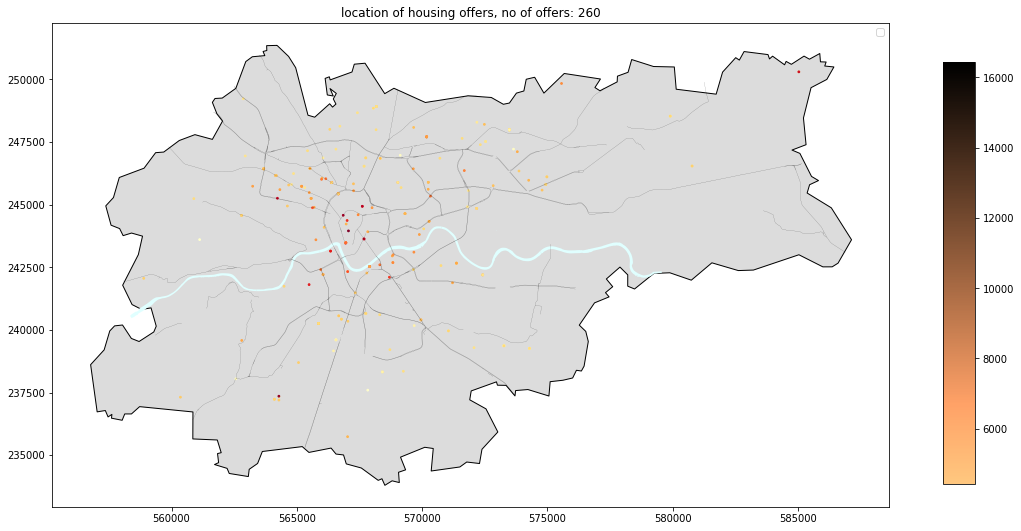

In [35]:
# plot geocoded offers
plt.rcParams['figure.figsize'] = (15, 15)
plt.rcParams['font.family'] = 'sans-serif'

krk_border = gpd.read_file(r'shp\krk_border.shp')
vistula = gpd.read_file(r'c:\Users\marci\git\Cracow_housing\shp\osm_vistula_92.shp')
rds = gpd.read_file(r'c:\Users\marci\git\Cracow_housing\shp\osm_rds_92.shp')

ax = krk_border.plot(color ='gainsboro', edgecolor='black')
ax.set_title("location of housing offers, no of offers: {}".format(liczba))
ax.legend()
vistula.plot(ax=ax, color='lightcyan');
rds.plot(ax=ax, color='black', linewidth = 0.1);
gdf.plot(ax=ax, marker='o',column='price', cmap='YlOrRd', markersize=3);

# colorbar will be created by ...
fig = ax.get_figure()
# add colorbar axes to the figure
# here, need trial-and-error to get [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.95, 0.3, 0.03, 0.39])   
colormap = "copper_r"   # add _r to reverse the colormap
sm = plt.cm.ScalarMappable(cmap=colormap, \
                norm=plt.Normalize(vmin=min(gdf.price), vmax=max(gdf.price)))
# at this stage, 
# 'cbax' is just a blank axes, with un needed labels on x and y axes

# blank-out the array of the scalar mappable 'sm'
sm._A = []
# draw colorbar into 'cbax'
fig.colorbar(sm, cax=cbax, format="%d")

# dont use: plt.tight_layout()
plt.show()

In [39]:
#wyswietlenie punktow na mapie, razem z pop ups
import folium

Mmap = folium.Map(location=[50.05, 19.95], zoom_start=12, )

def getColor(rodzaj):
    if rodzaj == 'opis':
        return 'blue'
    elif rodzaj == 'ulica':
        return 'red'
    else:
        return 'blue'

for lat, lon, opis, link, dzielnica, rodzaj, ulica in zip(located['latitude'], located['longitude'], located['opis'],
                                                          located['link'],  located['dzielnica'],  located['rodzaj'], 
                                                          located['ulica']):
        folium.CircleMarker(
            [lat, lon],
            radius=.15,
            popup = (str(link) +'<br>''<br>' + "zgeokodowano na podstawie : " + str(ulica)),
            color= getColor(rodzaj),
            key_on = ulica,
            threshold_scale=[0,1,2,3],
            fill_color = getColor(rodzaj),
            fill=True,
            fill_opacity=0.7
            ).add_to(Mmap)

Mmap

# geoenrichment - calculate distances: to city centre, to tram stops, to vistula_river and to parks

In [40]:
def haversine(row):
    import math
    lon1 = row['longitude']
    lat1 = row['latitude']

    # coords of the city center
    lon2 = 19.938 
    lat2 = 50.061

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    meters = R * c  # output distance in meters
    meters = round(meters)
    return(meters)

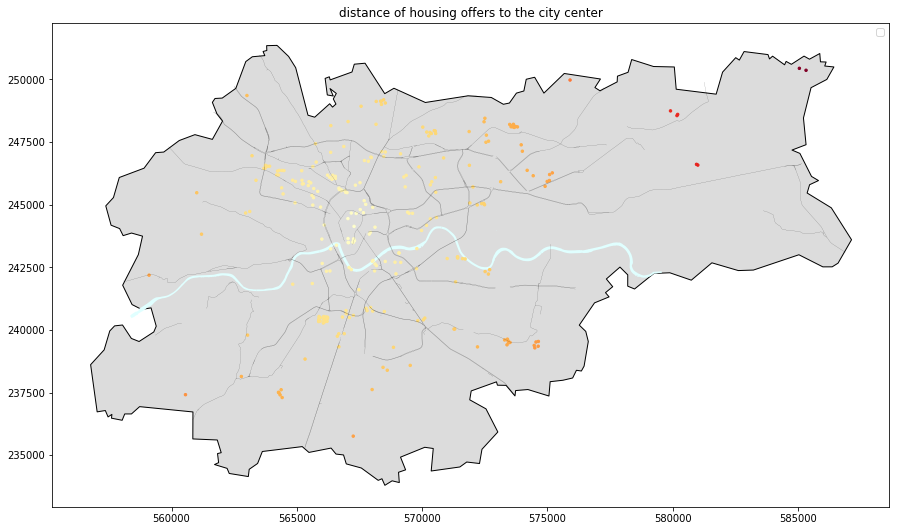

In [41]:
gdf['dst_center'] = gdf.apply(haversine, axis=1)
gdf.loc[gdf['dst_center'] < 15000]

ax = krk_border.plot(color='gainsboro', edgecolor='black')
ax.set_title("distance of housing offers to the city center")
ax.legend()
vistula.plot(ax=ax, color='lightcyan');
rds.plot(ax=ax, color='black', linewidth = 0.1);
gdf.plot(ax=ax, marker='o',column= 'dst_center', cmap='YlOrRd', markersize=6);